# Summary
- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
    - [10-fold-cross-validation-(early-stopping)](#10-fold-cross-validation-(early-stopping))
- [Evaluation](#Evaluation)
- [Visualization](#Visualization)
    - [Interpretation](#Interpretation)
- [Implemented-but-not-used](#Implemented-but-not-used)
    - [Debug](#Debug)

# Dependencies


In [46]:

#visualization
import matplotlib.pyplot as plt
#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
from scipy.signal import decimate
from scipy.spatial.transform import Rotation
from scipy.ndimage.interpolation import rotate
#machine learning
import torch
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)
#utils
from time import time
import warnings
from os.path import join
from os import listdir
import pickle

#custom
from utils import *
from load_data import *

cuda


In [2]:

data_gen=load_data()
"""data,targets=[],[]
for subject,label in data_gen:
    data.append(subject)
    targets.append(label)"""

'data,targets=[],[]\nfor subject,label in data_gen:\n    data.append(subject)\n    targets.append(label)'

In [35]:
subject,target=next(data_gen)

### Augmentation

In [36]:
def vertical_flip(task):
    vertical_ax=task[0][1]
    for i,point in enumerate(task[:,1]):
        if point < vertical_ax:
            task[i][1]=vertical_ax+(vertical_ax-point)
        else:
            task[i][1]=vertical_ax-(point-vertical_ax)
    return task
def horizontal_flip(task):
    horizontal_ax=task[0][0]
    for i,point in enumerate(task[:,0]):
        if point < horizontal_ax:
            task[i][0]=horizontal_ax+(horizontal_ax-point)
        else:
            task[i][0]=horizontal_ax-(point-horizontal_ax)
    return task
translation=np.random.rand()-0.5#because the std is one


In [37]:
task=scale(subject[0],axis=0)

In [46]:
h_flip=horizontal_flip(task.copy())
v_flip=vertical_flip(task.copy())
double_flip=horizontal_flip(v_flip.copy())

In [38]:
task[:,:2][0]

array([0.14734659, 0.00528515])

In [78]:
def rotate_(task, delta_rotate):
    horizontal_ax=task[0][0]#angle starts here
    vertical_ax=task[0][1]
    #x,y=1,1#task[20][1],task[20][0]#x, y
    for i, (y,x) in enumerate(task[:,:2]):
        #vector=[[vertical_ax,x],[horizontal_ax,y]]
        norm=np.linalg.norm([x-vertical_ax,y-horizontal_ax])
        #tan(angle)== opposed/adjacent$
        angle=np.arctan((horizontal_ax-y)/(vertical_ax-x)) if vertical_ax-x != 0.0 else 0.0
        new_angle=np.pi-(angle+delta_rotate)
        task[i][1]=np.cos(new_angle)*norm#new x
        task[i][0]=np.sin(new_angle)*norm#new y
    return task

In [79]:
rotated=rotate_(task.copy(),np.pi/10)

Text(0.5,1,'rotated')

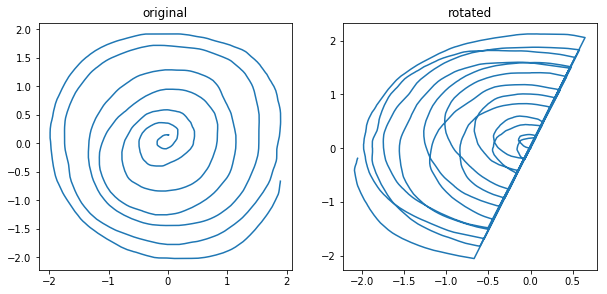

In [80]:

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(task[:,1],task[:,0])
plt.title("original")
plt.subplot(2,2,2)
plt.plot(rotated[:,1],rotated[:,0])
plt.title("rotated")

In [18]:
rotated

array([[0., 0.],
       [0., 0.]])

# Utils
Cf `utils.py`

In [82]:

def plot(plot_i,train,valid,test,average=True):
    if average:
        print(filename[12:].replace(",","|"))
        if early_stopping:
            title = "average {} over 10 folds over the {} first epochs".format(index2plot[plot_i],shortest_fold)
        else:
            title = "average {} over 10 folds over {} epochs".format(index2plot[plot_i],n_epochs)
    else :
        train,valid,test=np.asarray(train),np.asarray(valid),np.asarray(test)
        title=return_results([fold[-patience-1] for fold in fold_train_metrics],
                  [fold[-patience-1] for fold in fold_valid_metrics],
                  [fold[-patience-1] for fold in fold_test_metrics],
                  [len(fold)-patience for fold in fold_valid_metrics],[])[0:80].replace(";","|")
    plt.figure()
    plt.title(title)
    plt.plot(train[:,plot_i],label="training")
    plt.plot(valid[:,plot_i],label="validation")
    plt.plot(test[:,plot_i],label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()

def return_results(train_metrics,valid_metrics,test_metrics,early_stopping,flat_falses):
    train_metrics,valid_metrics,test_metrics=np.asarray(train_metrics),np.asarray(valid_metrics),np.asarray(test_metrics)
    model_name="LSTM" if is_lstm else "GRU"
    task_name=index2task[task_i] if task_i is not None else str(task_i)
    results="{} ; {} ; {} ; True ; True ; {} ; {}  ; {} ; {} ; {} ; {} ; {} ; {} ; {:.2f} (+ {:.2f}) ; {:.2f} (+ {:.2f}) ; {:.2f} (+ {:.2f}) ".format(
    task_name,model_name,compute_movement,downsampling_factor,learning_rate,
        hidden_size,num_layers,bidirectional,carry_over,dropout,clip,
    np.mean(early_stopping),np.std(early_stopping),np.mean(train_metrics[:,1]),np.std(train_metrics[:,1]),
    np.mean(valid_metrics[:,1]),np.std(valid_metrics[:,1]))

    test_metrics=test_metrics.T
    for metric in test_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        results+="; {:.2f} (+ {:.2f}) ".format(mean,std)
    results+=" ; "
    results+=" ; ".join(map(str, flat_falses))
    return results

# Data
## Loading
Cf `load_data.py`

In [3]:
data,targets=load_data()
print("(75-3 subjects, 8 tasks, X timesteps, 7 measures)")
print(len(data),len(data[0]),len(data[0][0]),len(data[0][0][0]))

(75-3 subjects, 8 tasks, X timesteps, 7 measures)
72 8 1772 7


## Task selection
set `task_i` to None if you want to train the model on all tasks at once (i.e. early fusion)  
Else set `task_i` to the desired task index (cf. task2index)

In [4]:
task_i=0
if task_i is not None:
    print(task_i,index2task[task_i])    
    #keep only one task
    data=[subject[task_i] for subject in data]
    #keep only one measure
    #data=[[[raw[i][task][j][6]] for j in range(len(raw[i][task])) ]  for i,subject in enumerate(raw) if len(raw[i][task])!=0]#discard the subjects that didn't perform spiral
else:
    print("task_i is None so we will use all tasks to train the model")
print("len(data), len(targets), len(data[0]) :")
print(len(data),len(targets),len(data[0]))

0 spiral
len(data), len(targets), len(data[0]) :
72 72 1772


## Compute movement
Transforms data as Zhang et al. (cf Report #5)

In [5]:
compute_movement=False
if compute_movement:
    print("computing movement")
    button_i=measure2index["button_status"]
    for i,task in enumerate(data):
        for t in range(len(task)-1):
            button=task[t+1][button_i]*task[t][button_i]
            data[i][t]=task[t+1]-task[t]
            data[i][t][button_i]=button
        data[i]=data[i][:-1]#throw out the last point
else:
    print("no modification was done")

no modification was done


## Scale then downsample (or not) then concatenate task id (or not)

In [6]:
downsampling_factor=1
for i,subject in enumerate(data):
    if task_i is not None:
        if downsampling_factor==1:#don't downsample
            if i ==0:
                print("scaling")
            data[i]=scale(subject,axis=0)
        else:
            if i ==0:
                print("scaling and downsampling")
            data[i]=decimate(
                scale(subject,axis=0),#scale first
                      downsampling_factor,axis=0)#then downsample
    else:
        for j, task in enumerate(subject):
            if downsampling_factor==1:#don't downsample    
                if i ==0 and j ==0:
                    print("scaling and concatenating task id")
                #concatenate task id and actual measures
                data[i][j]=np.concatenate(
                    ([one_hot[j] for _ in range(len(task))],#create a matrix of the same shape as the task
                     scale(task,axis=0)),#scales the task
                    axis=1)#then concatenate the two
            else:
                raise NotImplementedError("downsampling is not implemented for Multi-task learning")
print("len(data), len(targets), len(data[0]) :")
print(len(data),len(targets),len(data[0]))

scaling
len(data), len(targets), len(data[0]) :
72 72 1772


## Split in subsequence (or not)
Set `window_size` to `None` if you don't want to split data into subsequence of fixed length

In [7]:
window_size=None#Set to None if you don't want to split data into subsequence of fixed length
overlap=90
if window_size is not None:
    for i,task in enumerate(data):
        data[i]=[task[w:w+window_size] for w in range(0,len(task)-window_size,window_size-overlap)]
    print("len(data), data[0].shape, total n° of subsequences (i.e. training examples) :")
    print(len(data),",",len(data[0]),len(data[0][0]),len(data[0][0][0]),",",sum([len(subs) for subs in data]))
else:
    print("no modification was done")

no modification was done


# Model
Cf. Report #4 for details about the architecture of the model

- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch GRU doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

In [8]:
class Model(torch.nn.Module):
    """
    Args:
        #Vanilla LSTM/GRU
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
        
        #our model
        batch_size : default : 1
        output_size : default : 1 
        is_lstm : default : True
    """
    def __init__(self, input_size, hidden_size,num_layers=1, bias=True,batch_first=False,
                 dropout=0,bidirectional=False, batch_size=1, output_size=1,is_lstm=True):
        super(Model, self).__init__()
        #Vanilla LSTM/GRU
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias=bias
        self.batch_first=batch_first
        self.dropout=dropout
        self.bidirectional=bidirectional
        #our model
        self.batch_size = batch_size
        self.output_size = output_size
        self.is_lstm=is_lstm
        self.reset_hidden()
        # Define the encoder (i.e. GRU or LSTM) layer
        if self.is_lstm:
            self.encoder = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)
        else:
            self.encoder = torch.nn.GRU(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)
                    
        #define weight coefficient for "attention"
        #self.weight_coef=torch.nn.Parameter(torch.Tensor([-10]))
        
        #define the dropout layer
        self.dropout_layer=torch.nn.Dropout(self.dropout)      
        
        # Define the decoder layer
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
                
    def forward(self, input):
        # Forward pass through encoder layer
        # shape of encoder_out: (seq_len, batch, num_directions * hidden_size)
        # shape of self.hidden: (h_n, c_n), where hidden state h_n and cell state c_n both 
        # have shape (num_layers * num_directions, batch, hidden_size).
        if self.is_lstm:
            encoder_out, (self.hidden_state, self.cell_state) = self.encoder(input,(self.hidden_state, self.cell_state))
        else:#if GRU
            encoder_out, self.hidden_state= self.encoder(input,self.hidden_state)
            
        if self.bidirectional:
            #sums the outputs : direction left-right and direction right-left
            # encoder_out shape should now be (seq_len, batch,hidden_size)
            encoder_out = encoder_out[: ,: ,: self.hidden_size] + encoder_out[: , :, self.hidden_size: ]
                
        """UNABLE TO BACKPROP
        #fake attention to take into account all hidden states
        attn_weights=torch.Tensor(
            [torch.exp(self.weight_coef*(1-t/encoder_out.shape[0])) for t in range(encoder_out.shape[0]) ]
        ).unsqueeze(1).unsqueeze(1).to(device)#adds batch and hidden_size dim        
        encoding=attn_weights*encoder_out
        encoding=torch.sum(encoding,dim=0)"""
        
        # Only take the output from the final timestep
        encoding=encoder_out[-1]
        drop=self.dropout_layer(encoding)
        y_pred = self.linear(drop)
        y_pred = self.sigmoid(y_pred)
        return y_pred.squeeze(0)
    
    def reset_hidden(self):
        """
        For both GRU and LSTM :
        hidden_state of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial hidden state for each element in the batch. 
        If the RNN is bidirectional, num_directions should be 2, else it should be 1.
        
        For LSTM :
        cell_state of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial cell state for each element in the batch.
        
        The hidden state(s) is (are) modified in place."""
        
        num_directions=1
        if self.bidirectional:
            num_directions=2                    
        self.hidden_state=torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size,device=device)
        if self.is_lstm:
            self.cell_state=torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size,device=device)
    
    def init_forget_bias(self):
        """Following advices of Jozefowicz et al. 2015,
        we initialize the bias of the forget gate to a large value such as 1
        In PyTorch, the forget gate bias is stored as b_hf in bias_hh_l[k] : 
        the learnable hidden-hidden bias of the kth layer (b_hi|b_hf|b_hg|b_ho), of shape (4*hidden_size).
        So b_hf == bias_hh_lk[hidden_size:2*hidden_size]
        
        The weights are modified in-place, like reset_hidden(self).
        """
        gen=self.modules()
        _=next(gen)#model summary : don't care about it
        lstm=next(gen)
        if not isinstance(lstm,torch.nn.LSTM):
            raise NotImplementedError("the encoder should be an LSTM and should be the first module of the model")        
        with torch.no_grad():#so the optimizer doesn't know about this ;)
            lstm.bias_hh_l0[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.bidirectional:
                lstm.bias_hh_l0_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 1:
                lstm.bias_hh_l1[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
                if lstm.bidirectional:
                    lstm.bias_hh_l1_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 2:
                lstm.bias_hh_l2[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)    
                if lstm.bidirectional:
                    lstm.bias_hh_l2_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 3:
                lstm.bias_hh_l3[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)    
                if lstm.bidirectional:
                    lstm.bias_hh_l3_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 4:
                lstm.bias_hh_l4[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)    
                if lstm.bidirectional:
                    lstm.bias_hh_l4_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)                                    
            if lstm.num_layers>5:
                raise NotImplementedError("you can only have max 5 layers for now")
                
    def count_params(self):
        """returns (total n° of parameters, n° of trainable parameters)"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params

# Training
## step

In [9]:
def step(input, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()    
        
    # Set device options
    input=input.to(device)
    target=target.to(device)
        
    #forward pass
    output=model(input)
    
    # Compute loss
    loss = loss_fn(output, target)  
    if not validation:
        # Perform backpropagation
        loss.backward()
        if clip is not None:
            #clip gradients to previent exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Adjust model weights
        optimizer.step()        
        """# carry over regularization # useless if we reset hidden state for each subject
        if np.random.rand() <carry_over:
            model.reset_hidden() """  
    #reset hidden state after each step (i.e. after each subject OR each task OR each subsequence)
    model.reset_hidden()  
    
    """#continuous learning : choose between this and `model.reset_hidden() `
    #early results suggest that continuous learning make the loss unstable
    
    #we pass the hidden state from subject to subject !
    #but we detach it because we can't backprop through the whole dataset
    model.hidden_state=model.hidden_state.detach()
    if is_lstm:
        model.cell_state=model.cell_state.detach()"""
        
    return loss.item(), output.item()

## epoch

In [10]:
def epoch(data,targets, model, optimizer, loss_fn, batch_size, random_index,clip=None,validation=False):
    losses=[]
    predictions=[]
    condition_targets=[]
    
    if task_i is not None and window_size is None:#single task learning on the whole sequence
        for index in random_index:
            condition_targets.append(targets[index])
            #numpy to tensor
            subject=torch.Tensor(data[index]).unsqueeze(1)#add batch dimension        
            target=torch.Tensor([targets[index]])        

            loss, prediction =step(subject,target, model, optimizer, loss_fn, batch_size,clip,validation)
            predictions.append(round(prediction))
            losses.append(loss)        
    else:#multitask learning (early fusion) OR single task learning on subsequences            
        #if multitask learning len(data[i]) == 8 because 8 tasks
        super_index=[(i,j) for i in random_index for j in range(len(data[i]))]
        np.random.shuffle(super_index)
        if window_size is not None: #subsequences => we need to save predictions for late fusion (e.g. voting)
            predictions=dict(zip(random_index,[[] for _ in random_index]))
            condition_targets=[targets[i] for i in random_index]
        for i,j in super_index:#subject index, task index OR subsequence index
            if window_size is None:#we don't use the dictionary system so we have to keep track of the labels
                condition_targets.append(targets[i])
            #numpy to tensor
            #and add batch dimension   
            subject=torch.Tensor(data[i][j]).unsqueeze(1)     
            target=torch.Tensor([targets[i]])        
            loss, prediction =step(subject,target, model, optimizer, loss_fn, batch_size,clip,validation)
            if window_size is not None: #subsequences => we need to save predictions for late fusion (e.g. voting)
                predictions[i].append(prediction)
            else:#no late fusion => we just care about the label
                predictions.append(round(prediction))
            losses.append(loss)                  
    
    if window_size is not None: #subsequences => we need fuse the predictions of each sub seq (e.g. voting)
        #average over each model's prediction : choose between this and majority voting
        predictions=[round(np.mean(sub)) for sub in list(predictions.values())]
        
        #majority voting : choose between this and average fusion
        #predictions=[round(np.mean(list(map(round,sub)))) for sub in list(predictions.values())]
        
    #compute metrics
    tn, fp, fn, tp, false_i = confusion_matrix(y_true=condition_targets,y_pred=predictions)
    if task_i is not None:
        false=[random_index[i] for i in false_i]
    else:
        false=[random_index[i%len(random_index)] for i in false_i]
    accuracy= (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn) if (tp+fn) != 0 else 0.0 #without condition positives the sensitivity should be 0
    specificity = tn/(tn+fp) if (tn+fp)!= 0 else 0.0 #idem
    ppv = tp/(tp+fp) if tp+fp != 0 else 0.0 #without predicted positives the ppv should be 0
    npv = tn/(tn+fn) if tn+fn !=0 else 0.0 #idem
    
    return [np.mean(losses),accuracy,sensitivity,specificity,ppv,npv],false

## Hyperparameters

In [67]:
is_lstm=False
learning_rate = 1e-3
hidden_size=10
num_layers=4
bidirectional=False
dropout=0.0
clip=5.0#clipping value to clip the gradients norm : set to None if you don't want to clip

carry_over=0.0
if task_i is not None and window_size is None:#if we perform single task learning on the whole sequence
    input_size=len(data[0][0])#==7 if we take all the measures into account
else:
    input_size=len(data[0][0][0])#==7+8 if we train on multiple tasks, 7 if we train on subsequences (and single task)
bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control

loss_fn=torch.nn.BCELoss()#Binary cross entropy

NameError: name 'task_i' is not defined

## 10 fold cross validation (early stopping)
- set `run_CV` to `False` if you just want to train on one fold.
- set `early_stopping` to `False` if you just want to train on a fixed n° of epochs.

In [ ]:
#split in train valid and test set
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)
cv_matrix=[[tmp_index,test_index] for tmp_index,test_index in cv_generator]
for i,fold in enumerate(cv_matrix):
    #validate on the next fold test set (or on the first fold test set if last fold)
    #10 because 10 cross validation
    valid_index=cv_matrix[i+1][1] if i+1 < 10 else cv_matrix[0][2]
    #removes valid set from tmp_index
    train_index=[index for index in fold[0] if index not in valid_index]
    cv_matrix[i]=[train_index,valid_index,fold[1]]
    
verbose=False
fold_train_metrics,fold_valid_metrics,fold_test_metrics,fold_falses=[],[],[],[]
start = time()
np.random.seed(1)
save_to_print=""
fold=0
n_epochs=50#max n° of epochs the model will be trained to
patience = 10#n° of epochs without improvement during which the model will wait before stopping (if early_stopping)
run_CV=True#if False, breaks after one fold, else runs CV
early_stopping=True

for train_index,valid_index,test_index in cv_matrix:      
    train_metrics,valid_metrics,test_metrics,falses=[],[],[],[]

    torch.manual_seed(1)#random seed for weights init
    model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size, is_lstm)
    if isinstance(model.encoder,torch.nn.LSTM):
        model.init_forget_bias()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if fold==0:        
        print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())

    best_accuracy=0
    #best_loss=10000.0
    impatience=0
    for i in range(n_epochs):                
        to_print=""
        np.random.shuffle(train_index)#shuffle training to facilitate SGD        
        #training
        model.train()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
        train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #validation
        model.eval()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, valid_index,validation=True)    
        valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)      

        #patience update        
        if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
            impatience+=1
        else:
            best_accuracy=accuracy #best_loss=loss#
            impatience=0
            
        #test
        [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
        test_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        falses.append(false)
        to_print+="\nTEST : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)        

        if verbose:
            print(to_print)
        save_to_print+=to_print
        
        #early stopping
        if impatience >= patience and early_stopping:
            save_to_print+="\nEarly stopped."
            break     

    fold_train_metrics.append(train_metrics)
    fold_valid_metrics.append(valid_metrics)
    fold_test_metrics.append(test_metrics)
    fold_falses.append(falses)
    fold+=1
    if not run_CV:
        break
if not verbose:
    print("done")#save_to_print)

(total n° of parameters, n° of trainable parameters)
 (2561, 2561)


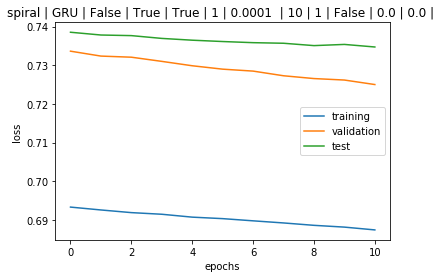

In [120]:
plot(0,train_metrics,valid_metrics,test_metrics,False)

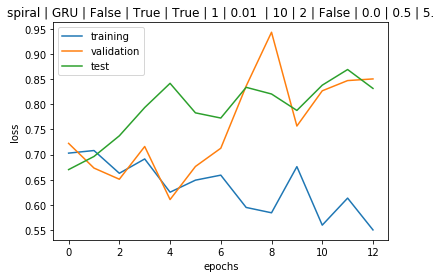

In [117]:
plot(0,train_metrics,valid_metrics,test_metrics,False)

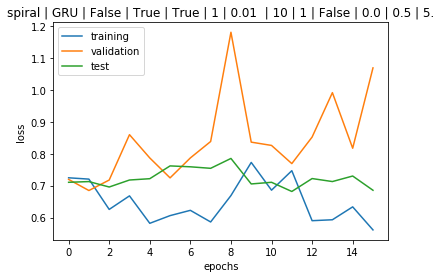

In [114]:
plot(0,train_metrics,valid_metrics,test_metrics,False)

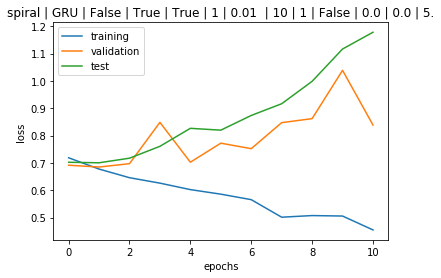

In [110]:
plot(0,train_metrics,valid_metrics,test_metrics,False)

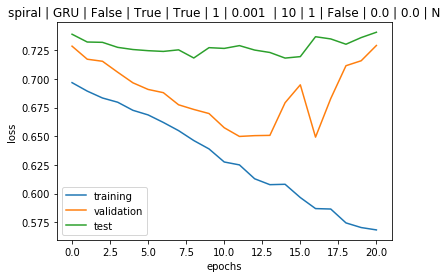

In [96]:
plot(0,train_metrics,valid_metrics,test_metrics,False)

# Evaluation

In [66]:
if early_stopping:
    folds_lengths=[len(fold) for fold in fold_valid_metrics]
    print("number of epochs before early stopping for each fold:\n",folds_lengths)
    longest_fold=np.argmax(folds_lengths)
    shortest_fold=np.min(folds_lengths)
    average_stop=int(round(np.mean(folds_lengths)-patience))-1#-1 to index to it
    med_stop=int(round(np.median(folds_lengths)-patience-1))#-1 to index to it

number of epochs before early stopping for each fold:
 [14, 18, 13, 14, 13, 13, 13, 15, 15, 13]


NameError: name 'patience' is not defined

In [72]:
n_epochs=50

In [73]:
try:
    if early_stopping:
        assert np.max([len(fold) for fold in fold_valid_metrics]) < n_epochs
        best_index=-patience-1
        stopped_at=[len(fold)-patience for fold in fold_valid_metrics]
    else:
        best_index=-1        
        stopped_at=[n_epochs]
except AssertionError:
    print("The model didn't early stop therefore fold[-patience-1] is not the best epoch")    
else:    
    best_falses=[fold[best_index] for fold in fold_falses]
    flat_falses = sorted(flat_list(best_falses))
    results=return_results([fold[best_index] for fold in fold_train_metrics],
                  [fold[best_index] for fold in fold_valid_metrics],
                  [fold[best_index] for fold in fold_test_metrics],
                  stopped_at,
                   flat_falses)
    print(results)

NameError: name 'fold_falses' is not defined

## 10 fold cross validation with early stopping
**Available in the git repo :**  `experiment results.ods`  
**Cf Report #4 for analysis**   
/!\ validating on the test set /!\  
Average metric over the 10 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
early stopped : n° of epochs + std  
Every metric is for the validation set if not specified otherwise  
The studied hyperparameter is printed in **bold**.  


# Visualization

### Load results

In [61]:
listdir("experiments")[0][:-4]

'(0, False, 0.001, 10, 4, False, 0.0, 5.0, None)'

In [62]:
filename="experiments/"+listdir("experiments")[0][:-4]
early_stopping=True
metrics=[]
for metric_type in ["train","valid","test"]:
    with open (filename+metric_type, 'rb') as fp:
        metrics.append(pickle.load(fp))

In [63]:
fold_train_metrics,fold_valid_metrics, fold_test_metrics=metrics

In [68]:
patience=10
if early_stopping:
    avg_train=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_train_metrics]),axis=0)
    avg_valid=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_valid_metrics]),axis=0)
    avg_test=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_test_metrics]),axis=0)
else:
    avg_train=np.mean(fold_train_metrics,axis=0)
    avg_valid=np.mean(fold_valid_metrics,axis=0)
    

'(0, False, 0.001, 10, 4, False, 0.0, 5.0, None)'

(0| False| 0.001| 10| 4| False| 0.0| 5.0| None)


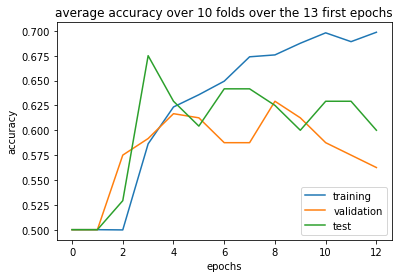

In [86]:
plot(1,avg_train,avg_valid,avg_test)

## Loss

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)  
Adding an extra layer gives the same behaviour, more or less 

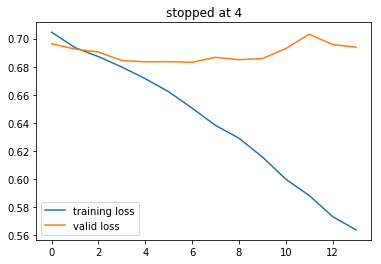

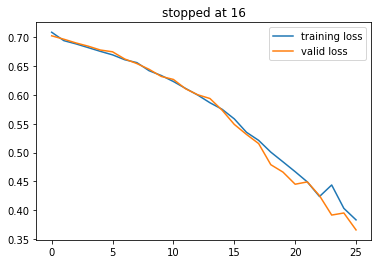

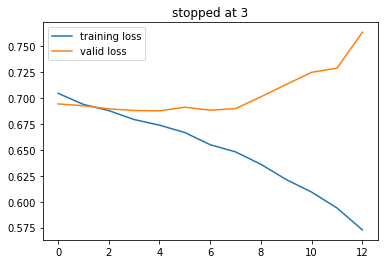

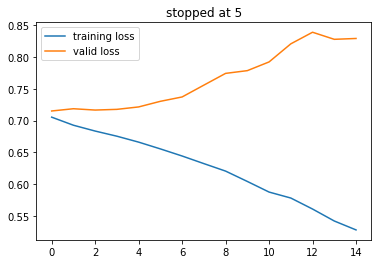

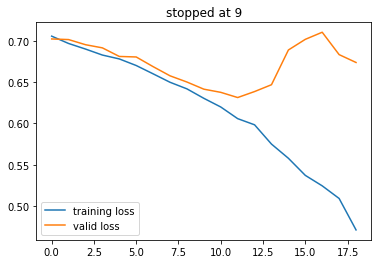

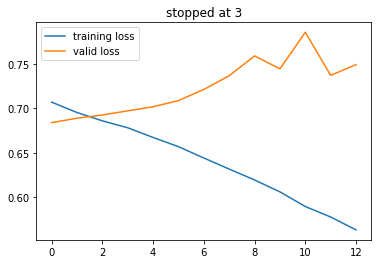

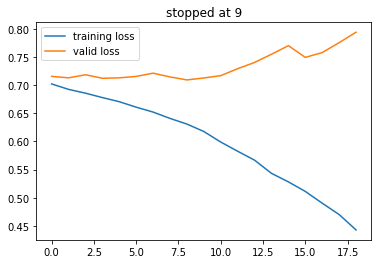

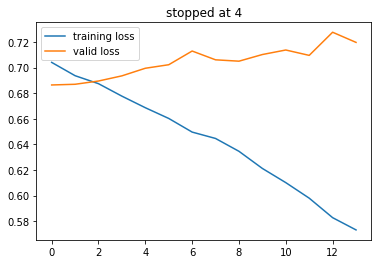

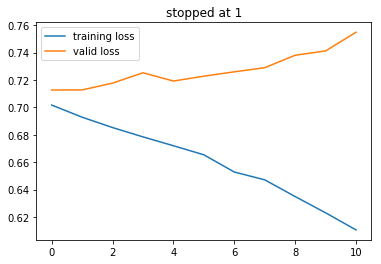

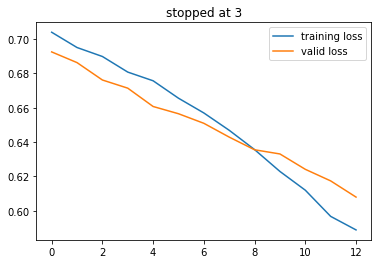

In [179]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,0],label="training loss")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,0],label="valid loss")
    plt.legend()

In [95]:
np.std([np.max(fold,axis=0)[1] for fold in fold_test_metrics])

0.11094605796411958

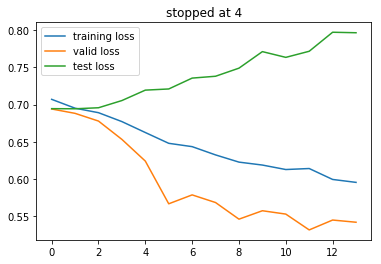

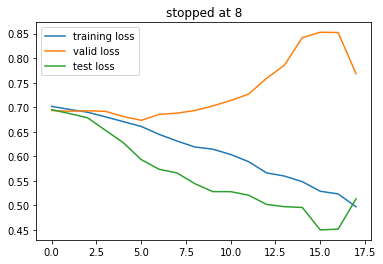

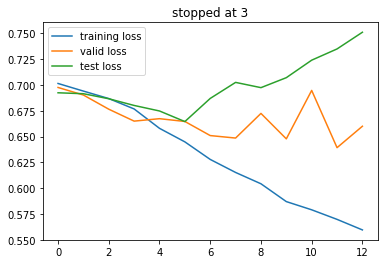

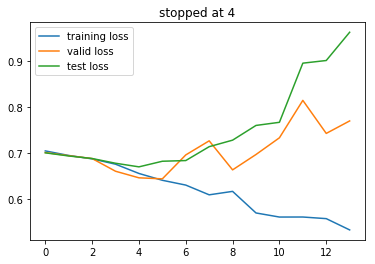

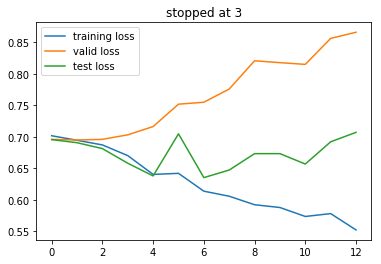

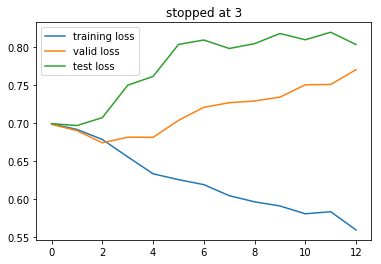

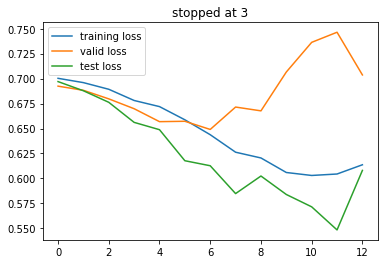

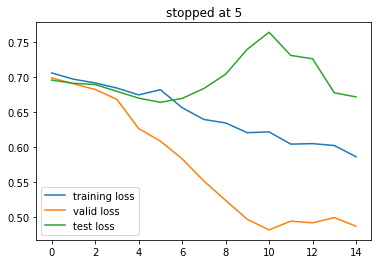

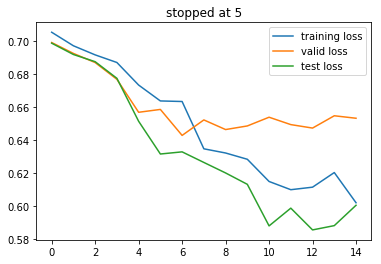

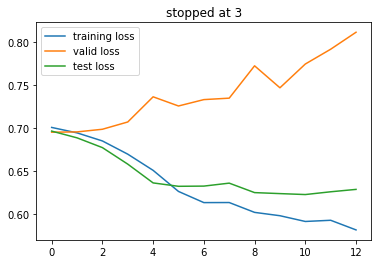

In [87]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,0],label="training loss")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,0],label="valid loss")
    plt.plot(np.asarray(fold_test_metrics[i])[:,0],label="test loss")
    plt.legend()

##### Stronger effect with 4 layers
but the specificity boost comes back  

task|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|carry over | dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--
spiral | 1 | 0.001 | 10 | 4 | True |0| 0.5 | 5.0 | 5.50 (+ 3.35) 

![4layers.png](4layers.png)

##### The model doesn't behave the same way with the l task (with 2 or 3 layers)
task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
l | 1 | 0.001 | 10 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.31)

l | 1 | 0.001 | 10 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.31)


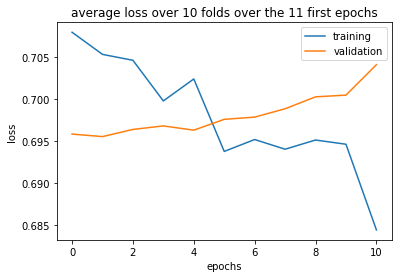

#####  Nor with the tram task

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
tram | 1 | 0.001 | 10 | 2 | True | 0.0 | 0.0 | 5.0 | 5.30

![tram](tram.png)

#####  Computing movement as Zhang et al. helps with the l task

task	| Model | Computing movement | dowsampling factor |learning_rate | hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--|--
l | GRU | True | 1 | 0.001 | 10 | 4 | False | 0.0 | 0.0 | 5.0 | 4.60 (+ 2.94) 


l | GRU | True | 1 | 0.001 | 10 | 4 | False | 0.0 | 0.0 | 5.0 | 4.60 (+ 2.94) | 


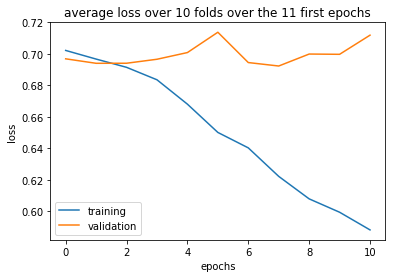

In [136]:
plot_loss()

## Accuracy

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
**0.0001** | 100 | 1 | True | 0.0 | 5.0 | 14.80 (+ 12.37) | 0.63 (+ 0.09) | 0.71 (+ 0.09) | 0.55 (+ 0.27) | 0.87 (+ 0.18) | 0.88 (+ 0.15) | 0.70 (+ 0.16) 

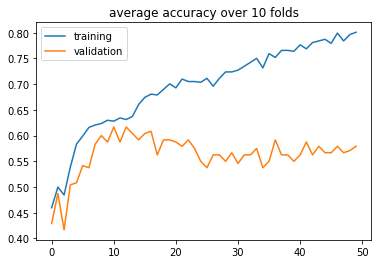

In [104]:
plt.figure()
plt.title("average accuracy over 10 folds")
plt.plot(avg_train[:,1],label="training")
plt.plot(avg_valid[:,1],label="validation")
plt.legend()

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)

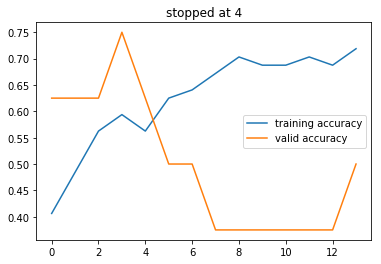

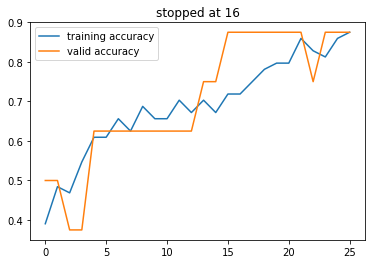

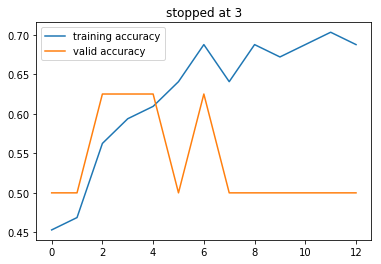

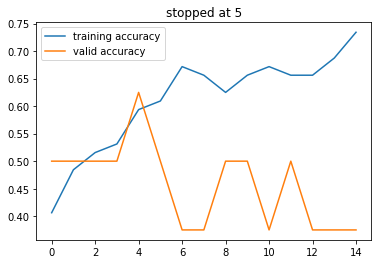

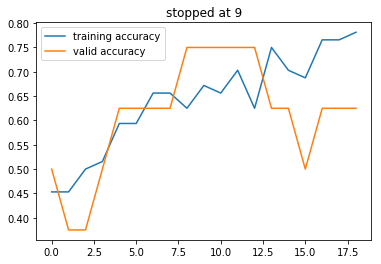

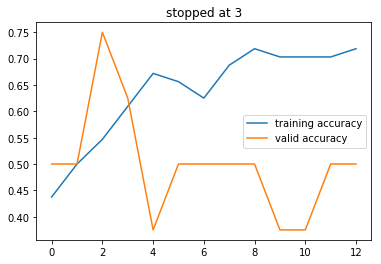

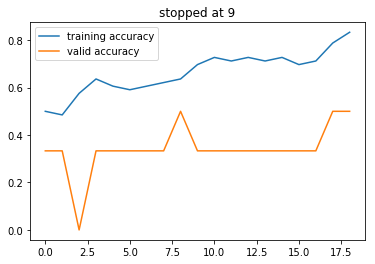

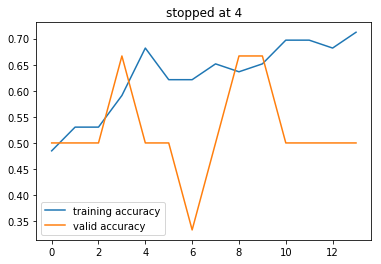

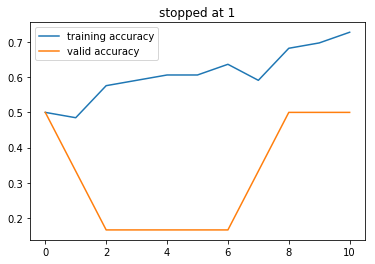

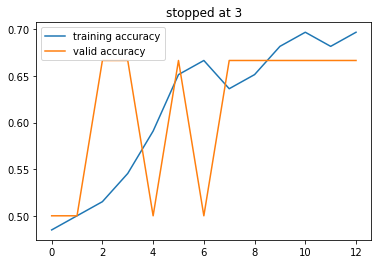

In [180]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training accuracy")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,1],label="valid accuracy")
    plt.legend()

##  Interpretation

###  Falses

<Figure size 432x288 with 0 Axes>

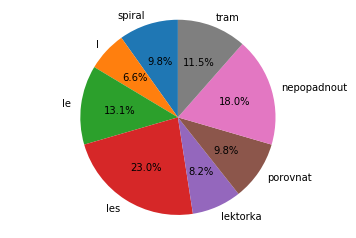

<Figure size 432x288 with 0 Axes>

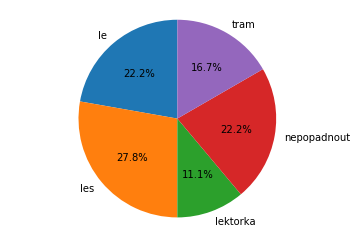

In [492]:
"""figure from the defect implementation !"""
for indexes in [test_index,fold_falses[-2][2]]:
    test_classes=np.argmax([data[i][0][0:8] for i in indexes],axis=1)
    unique,counts=np.unique(test_classes, return_counts=True)
    plt.figure()
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [index2task[i] for i in unique]
    sizes = counts
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

### Experiments metrics

In [1]:
raw_results="""10	4	TRUE	0	0.5	5	 5.50 (+ 3.35) 	 0.58 (+ 0.10) 	 0.72 (+ 0.15) 	 0.65 (+ 0.38) 
10	3	TRUE	0	0.5	5	 4.90 (+ 4.01) 	 0.59 (+ 0.08) 	 0.72 (+ 0.16) 	 0.84 (+ 0.21) 
10	2	TRUE	0	0.5	5	 4.20 (+ 3.76) 	 0.56 (+ 0.08) 	 0.70 (+ 0.07) 	 0.57 (+ 0.21) 
10	2	TRUE	0.1	0.5	5	 3.40 (+ 2.58) 	 0.57 (+ 0.07) 	 0.71 (+ 0.12) 	 0.45 (+ 0.24) 
10	1	TRUE	0	0.5	5	 3.40 (+ 2.24) 	 0.53 (+ 0.04) 	 0.63 (+ 0.10) 	 0.90 (+ 0.17) 
50	1	TRUE	0	0.5	5	 5.70 (+ 6.78) 	 0.64 (+ 0.13) 	 0.73 (+ 0.11) 	 0.65 (+ 0.20) 
50	2	TRUE	0	0.5	5	 2.30 (+ 2.00) 	 0.52 (+ 0.08) 	 0.66 (+ 0.11) 	 0.68 (+ 0.27) 
100	1	TRUE	0	0.5	5	 5.00 (+ 4.49) 	 0.62 (+ 0.08) 	 0.74 (+ 0.16) 	 0.72 (+ 0.31) 
100	2	TRUE	0	0.5	5	 4.70 (+ 4.00) 	 0.59 (+ 0.07) 	 0.71 (+ 0.15) 	 0.67 (+ 0.31) 
100	3	TRUE	0	0.5	5	 4.70 (+ 3.10) 	 0.57 (+ 0.07) 	 0.68 (+ 0.10) 	 0.70 (+ 0.24) """

results=[r.split("\t") for r in raw_results.split("\n")]

len(results)

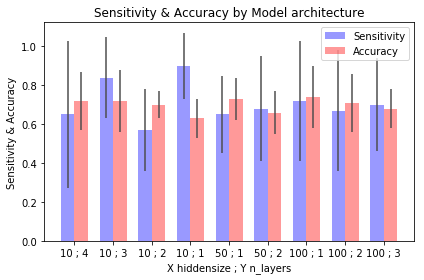

In [34]:
n_groups = len(results)

studied_metric = tuple([float(i[-1][0:5]) for i in results])#(0.74, 0.63, 0.7)
studied_std = tuple([float(i[-1][8:13]) for i in results])#(0.16, 0.1, 0.07)

accuracy_vanilla = tuple([float(i[-2][0:5]) for i in results])
std_vanilla = tuple([float(i[-2][8:13]) for i in results])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, studied_metric, bar_width,
                alpha=opacity, color='b',
                yerr=studied_std, error_kw=error_config,
                label='Sensitivity')

rects2 = ax.bar(index + bar_width, accuracy_vanilla, bar_width,
                alpha=opacity, color='r',
                yerr=std_vanilla, error_kw=error_config,
                label='Accuracy')

ax.set_xlabel('X hiddensize ; Y n_layers')
ax.set_ylabel('Sensitivity & Accuracy')
ax.set_title('Sensitivity & Accuracy by Model architecture')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(tuple([i[0]+" ; "+i[1] for i in results]))#('100 ; 1', '10 ; 1', '10 ; 2'))
ax.legend()

fig.tight_layout()
plt.show()

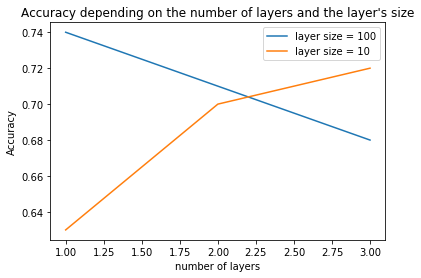

In [124]:
plt.figure()

plt.title("Accuracy depending on the number of layers and the layer's size")
plt.plot(range(1,4),[0.74,0.71,0.68],label="layer size = 100")
plt.plot(range(1,4),[0.63,0.7,0.72],label="layer size = 10")
#plt.errorbar(range(1,4),[0.74,0.71,0.68],[0.16,0.07,0.1],label="layer size = 100", marker='^')
#plt.errorbar(range(1,4),[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')
plt.xlabel("number of layers")
plt.ylabel("Accuracy")
plt.legend()

## Model weights

In [596]:
fold_train_metrics[0]

[[0.7049412904307246, 0.53125, 0.1875, 0.875, 0.6, 0.5185185185185185]]

In [316]:
print("""the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size) if LSTM and 
(W_ir|W_iz|W_in) of shape (3*hidden_size x input_size) if GRU""")
print(model.encoder.weight_ih_l0.shape)#lstm.weight_ih_l0.shape)
input_weights=model.encoder.weight_ih_l0.cpu().detach().numpy()

the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size) if LSTM and 
(W_ir|W_iz|W_in) of shape (3*hidden_size x input_size) if GRU
torch.Size([30, 15])


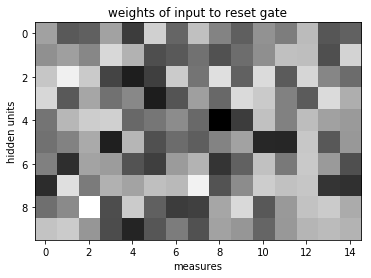

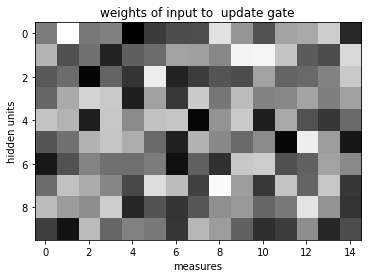

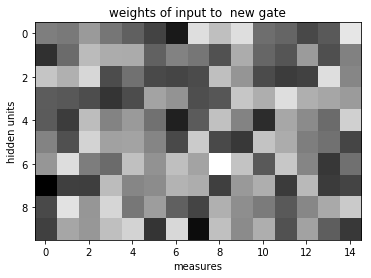

In [317]:
"""figure from the defect implementation !"""
plot_labels="reset gate, update gate, new gate".split(",")
for i,label in enumerate(plot_labels):
    plt.figure()
    plt.title("weights of input to {}".format(label))
    plt.xlabel("measures")
    plt.ylabel("hidden units")
    plt.imshow(input_weights[i*10:i*10+10],cmap='gray')

#### Biases after init at 1


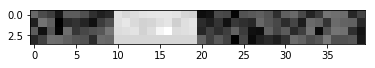

In [358]:
biases=[lstm.bias_hh_l0,
lstm.bias_hh_l0_reverse,
lstm.bias_hh_l1,
lstm.bias_hh_l1_reverse]
for i,b in enumerate(biases):
    biases[i]=b.cpu().detach().numpy()
plt.imshow(biases,cmap='gray')

# Implemented but not used

## Trimming and padding
For spirals we set max_len at 3117 as it's the 3rd quartile of task lengths (i.e. 3/4 subjects have task shorter than 3117 timesteps)

In [10]:
"""
if task_i is None:
    raise NotImplementedError("Multi-task learning is not implemented for trimming and padding")
max_len=3117
for i,task in enumerate(data):
    
    if len(task) > max_len:
        data[i]=task[:max_len]
    else:
        data[i]=np.concatenate((task,np.zeros(shape=(max_len-len(task),7))))"""
print("With this trimming and padding the model won't fit with the same hyperparameters")


With this trimming and padding the model won't fit with the same hyperparameters


## MAB Optim

In [199]:
actions={"increment":0,"idle":1,"decrement":2}
#pessimistic init (reward == loss). 3 because 3 actions
qtable={"is_lstm":np.ones(len(actions)),"learning_rate":np.ones(len(actions)),
        "hidden_size":np.ones(len(actions)),
        "num_layers":np.ones(len(actions)),"bidirectional":np.ones(len(actions)),
        "dropout":np.ones(len(actions)),"clip":np.ones(len(actions))}

hyperparameters_range={"is_lstm":[True,False],
                 "learning_rate":[1e-2,1e-3,1e-4],
                 "hidden_size":[2**i for i in range (1,8)],
                 "num_layers":[i for i in range (1,6)],
                 "bidirectional":[True,False],
                 "dropout":np.arange(0,0.6,0.1),
                 "clip":[1,5,10,50,None]}
#index for hyperparameters_range
hyperparameters={"is_lstm":1,
                 "learning_rate":1,
                 "hidden_size":2,
                 "num_layers":1,
                 "bidirectional":0,
                 "dropout":2,
                 "clip":1}
q_decay_rate = 0.03
q_learning_rate = 0.5

In [170]:
episode = 0
experiments=[]
while True:
    q_exploration_rate=np.exp(-q_decay_rate*episode)#exploration rate update
    save_actions=[]#to update qtable later
    for p in hyperparameters.keys():#choose every hyperparam 
        
        #define what action the agent is able to take
        choose_from=[actions["idle"]]
        if hyperparameters[p]+1 < len(hyperparameters_range[p]):#if we can increment
            choose_from.append(actions["increment"])
        elif hyperparameters[p] > 0:#if we can decrement   
            choose_from.append(actions["decrement"])
            
        if np.random.rand()<q_exploration_rate:#exploration (i.e. random choice)
            action=np.random.choice(choose_from)
        else:
            #"removes" unallowed actions from the qtable
            #replace 1000 with 0 if optimizing accuracy
            allowed_table=[q if i in choose_from else 1000 for i,q in enumerate(qtable[p])]
            action=np.argmin(allowed_table)#argmin because we want to MINimize LOSS        
            
        if action==actions["increment"]:            
            hyperparameters[p]+=1
        elif action==actions["idle"]:
            pass#idle
        elif action==actions["decrement"]:
            hyperparameters[p]-=1
        else:
            raise ValueError("incorrect action index {},expected one of {}".format(action,actions))
        save_actions.append(action)#to update qtable later
    
    #take action (e.g. 10 CV)
    is_lstm=hyperparameters_range["is_lstm"][hyperparameters["is_lstm"]]
    learning_rate = hyperparameters_range["learning_rate"][hyperparameters["learning_rate"]]
    hidden_size=hyperparameters_range["hidden_size"][hyperparameters["hidden_size"]]
    num_layers=hyperparameters_range["num_layers"][hyperparameters["num_layers"]]
    bidirectional=hyperparameters_range["bidirectional"][hyperparameters["bidirectional"]]
    dropout=hyperparameters_range["dropout"][hyperparameters["dropout"]]
    clip=hyperparameters_range["clip"][hyperparameters["clip"]] 
    
    print("\nepisode n°{}, hyperparameters :\n {} ; {} ; {} ; {} ; {} ; {} ; {}".format(
    episode,is_lstm,learning_rate,hidden_size,num_layers,bidirectional,dropout,clip))
    
    verbose=False
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_generator=skf.split(data,targets)
    fold_train_metrics,fold_valid_metrics,fold_falses=[],[],[]
    start = time()
    np.random.seed(1)
    save_to_print=""
    fold=0
    n_epochs=50#max n° of epochs the model will be trained to
    patience = 10#n° of epochs without improvement during which the model will wait before stopping

    for train_index,test_index in cv_generator:     
        train_metrics,valid_metrics,falses=[],[],[]

        torch.manual_seed(1)#random seed for weights init
        model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                     dropout,bidirectional, batch_size, output_size, is_lstm)
        if isinstance(model.encoder,torch.nn.LSTM):
            model.init_forget_bias()
        model=model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        if fold==0:        
            print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())

        best_accuracy=0
        #best_loss=10000.0
        impatience=0
        for i in range(n_epochs):                
            to_print=""
            np.random.shuffle(train_index)
            np.random.shuffle(test_index)
            #training
            model.train()
            [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
            train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
            to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
            to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

            #validation
            model.eval()
            [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
                data, targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
            valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
            falses.append(false)
            to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
                loss,accuracy,sensitivity,specificity,ppv,npv)      

            #patience update        
            if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
                impatience+=1
            else:
                best_accuracy=accuracy #best_loss=loss#
                impatience=0

            if verbose:
                print(to_print)
            save_to_print+=to_print

            #early stopping
            if impatience >= patience:
                save_to_print+="\nEarly stopped."
                break     

        fold_train_metrics.append(train_metrics)
        fold_valid_metrics.append(valid_metrics)
        fold_falses.append(falses)
        fold+=1
    if not verbose:
        print(to_print)#save_to_print)
    experiments.append((fold_train_metrics,fold_valid_metrics,fold_falses,is_lstm,learning_rate,hidden_size,
                       num_layers,bidirectional, dropout,clip))
    #take reward : average loss over the best folds
    if np.max([len(fold) for fold in fold_valid_metrics]) >= n_epochs:
        print("episode n°{}, Warning : the model didn't early stopped therefore we didn't selected the best metric")
    
    reward=np.mean(np.asarray([fold[-patience-1] for fold in fold_valid_metrics])[:,0])
    #update qtable
    for i,p in enumerate(qtable):
        action=save_actions[i]
        qtable[p][action]+=q_learning_rate*(reward-qtable[p][action])
    episode+=1
              

episode n°0, hyperparameters :
 False ; 0.001 ; 128 ; 4 ; True ; 0.4 ; 1
(total n° of parameters, n° of trainable parameters)
 (994689, 994689)


fold n°9, epoch n°18, spent 350m 10s
TRAINING : loss 1.187, accuracy 0.636
VALIDATION : loss 2.055, accuracy 0.500, sensitivity  0.667, specificity 0.333, ppv 0.500, npv 0.500
episode n°1, hyperparameters :
 False ; 0.001 ; 64 ; 5 ; True ; 0.4 ; 5
(total n° of parameters, n° of trainable parameters)
 (326081, 326081)


fold n°9, epoch n°10, spent 244m 37s
TRAINING : loss 0.708, accuracy 0.515
VALIDATION : loss 0.693, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000
episode n°2, hyperparameters :
 False ; 0.001 ; 64 ; 4 ; True ; 0.5 ; 5
(total n° of parameters, n° of trainable parameters)
 (251585, 251585)


fold n°9, epoch n°10, spent 178m 54s
TRAINING : loss 0.703, accuracy 0.606
VALIDATION : loss 0.693, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000
episode n°3, hyperparameters :
 True

KeyError: 'learning_rate'

## Debug

In [130]:
torch.manual_seed(1)
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
if isinstance(model.encoder,torch.nn.LSTM):
    model.init_forget_bias()
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

subject=torch.Tensor(data[61][0]).unsqueeze(1)
target=torch.Tensor([targets[61]])
subject=subject.to(device)
target=target.to(device)
step(subject, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False)
#we pass the hidden state from subject to subject !
#but we detach it because we can't backprop through the whole dataset
model.hidden_state=model.hidden_state.detach()
if is_lstm:
    model.cell_state=model.cell_state.detach()

## Old cross validation (no test set)

In [ ]:
verbose=False
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)
fold_train_metrics,fold_valid_metrics,fold_test_metrics,fold_falses=[],[],[],[]
start = time()
np.random.seed(1)
save_to_print=""
fold=0
n_epochs=50#max n° of epochs the model will be trained to
patience = 10#n° of epochs without improvement during which the model will wait before stopping (if early_stopping)
run_CV=False#if False, breaks after one fold, else runs CV
early_stopping=True

for tmp_index,test_index in cv_generator:  